In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
from fastprogress import progress_bar
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from skimage import io, transform
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import urllib.request

from preprocess import load, generator
from utils import plot_labelled_image, plot_labelled_sample

Using TensorFlow backend.


In [3]:
images_path = '../data/images/'
labels_path = '../data/landmarks.csv'
target_size = 160

In [5]:
X, y = load(images_path, labels_path, target_size)

X_train, X_test_, y_train, y_test_ = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

In [25]:
y.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y
filename,,,,,,,,,,,,,,,,,,,,,
Abyssinian_1.jpg,90.400002,52.399998,90.400002,31.199999,101.333328,40.400002,111.733330,30.799999,111.199997,52.399998,...,96.533340,48.800003,104.533325,49.200001,97.600006,59.599998,99.466667,57.600002,102.666664,59.599998
Abyssinian_100.jpg,63.350254,63.360001,76.751266,32.639999,99.492386,40.000000,134.010147,25.280001,131.573608,57.600002,...,92.588837,61.440002,118.984772,59.200001,102.741119,81.279999,111.269035,78.400002,118.578682,80.000000
Abyssinian_102.jpg,30.400000,80.860214,8.960000,27.526882,62.719997,37.161289,101.440002,11.354838,101.759995,65.720428,...,50.560001,72.258064,80.319992,69.161293,57.600002,105.978500,67.839996,101.161285,77.760002,102.881714
Abyssinian_103.jpg,85.760002,75.213676,77.760002,46.039886,96.639999,46.951565,113.279999,32.364670,115.520004,65.185181,...,95.039993,71.111115,107.840004,67.464386,101.440002,87.977211,104.320000,86.609688,108.160004,85.698006
Abyssinian_105.jpg,80.319992,72.959999,76.479996,45.226665,97.600006,45.226665,118.720001,45.226665,114.239998,71.680000,...,90.240005,77.653336,104.960007,77.653336,93.760002,95.573334,97.279999,95.146667,100.800003,96.000000


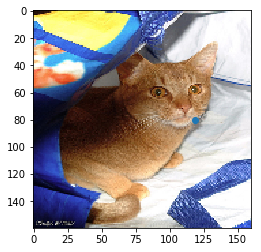

In [47]:
plt.imshow(X[1])
plt.scatter(y.iloc[1][20], y.iloc[1][21])

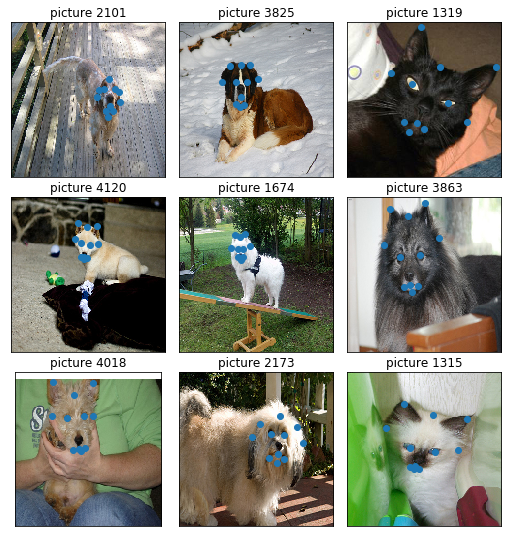

In [10]:
plot_labelled_sample(X_train, y_train, target_size, False)

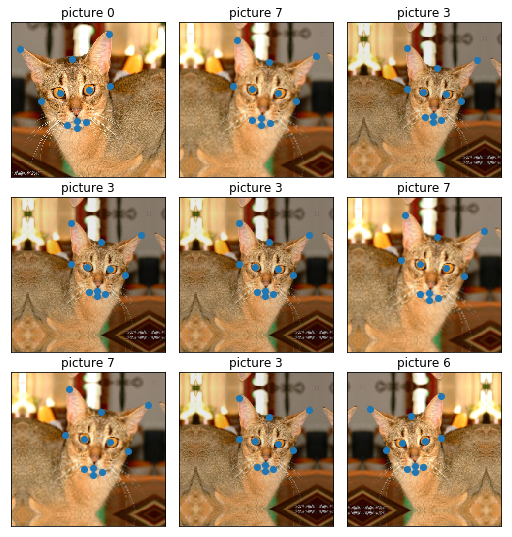

In [11]:
for a, b in generator(X[2:3], y.iloc[2:3], 9, target_size):
    plot_labelled_sample(a, b, target_size)   
    break

In [44]:
landmarks_frame = pd.read_csv('../data/cleaned_labels.csv')

n = 22
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].values
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: Abyssinian_124.jpg
Landmarks shape: (11, 2)
First 4 Landmarks: [[50.45044708 50.87999725]
 [43.24324036 31.04000092]
 [71.59159088 36.47999954]
 [98.97897339 32.31999969]]


# Load uploaded images and labels

In [310]:
all_data = pd.read_json(
    'https://content.mytalkingpet.app/templates?_start=14000&_limit=10&_sort=createdAt:DESC'
)

# 'https://content.mytalkingpet.app/templates?_limit=100&_sort=createdAt:DESC'

all_data = all_data[[
    'uploadedImage',
    'leftHeadPoint', 
    'leftEarPoint',
    'topHeadPoint',
    'rightEarPoint',
    'rightHeadPoint',
    'chinPoint',
    'leftEyePoint',
    'rightEyePoint',
    'leftMouthPoint',
    'centreMouthPoint',
    'rightMouthPoint'
]]

kp_cols = [
    'leftHeadPoint', 
    'leftEarPoint',
    'topHeadPoint',
    'rightEarPoint',
    'rightHeadPoint',
    'chinPoint',
    'leftEyePoint',
    'rightEyePoint',
    'leftMouthPoint',
    'centreMouthPoint',
    'rightMouthPoint'
]

all_data = all_data.dropna()

def items(a_set):
    xy = list()
    for letter in a_set:
        xy.insert(0, letter)
    if len(a_set) < 2:
        xy.append(xy[0])
    return xy

for col in kp_cols:
    all_data[col] = all_data[col].apply(ast.literal_eval)
    all_data[col] = all_data[col].apply(items)

    all_data[col+'_x'], all_data[col+'_y'] = zip(*all_data[col])
    
    all_data = all_data.drop(col, axis=1)

uploadImageDf = pd.DataFrame(all_data['uploadedImage'].values.tolist())
all_data['hash'] = uploadImageDf['hash'].values

In [311]:
for i in progress_bar(range(all_data.shape[0])):
    urllib.request.urlretrieve(
        all_data.iloc[i]['uploadedImage']['url'], 
        "../data/uploaded_images/{}.png".format(all_data.iloc[i]['hash'])
    )

In [312]:
all_data = all_data.drop('uploadedImage', axis=1)

def add_png(hashes):
    return hashes + '.png'

all_data['hash'] = all_data['hash'].apply(add_png)

In [313]:
all_data = all_data[[
    'leftHeadPoint_x', 'leftHeadPoint_y',
    'leftEarPoint_y', 'leftEarPoint_x',
    'topHeadPoint_x', 'topHeadPoint_y',
    'rightEarPoint_x', 'rightEarPoint_y',
    'rightHeadPoint_x', 'rightHeadPoint_y',
    'chinPoint_y', 'chinPoint_x', 
    'leftEyePoint_x', 'leftEyePoint_y',
    'rightEyePoint_y', 'rightEyePoint_x', 
    'leftMouthPoint_y', 'leftMouthPoint_x', 
    'centreMouthPoint_x', 'centreMouthPoint_y',
    'rightMouthPoint_y', 'rightMouthPoint_x', 
    'hash'
]]

all_data.rename(
    columns={
        'leftHeadPoint_x': '0_x', 'leftHeadPoint_y': '0_y',
        'leftEarPoint_x': '1_x', 'leftEarPoint_y': '1_y',
        'topHeadPoint_x': '2_x', 'topHeadPoint_y': '2_y',
        'rightEarPoint_x': '3_x', 'rightEarPoint_y': '3_y',
        'rightHeadPoint_x': '4_x', 'rightHeadPoint_y': '4_y',
        'chinPoint_x': '5_x', 'chinPoint_y': '5_y',
        'leftEyePoint_x': '6_x', 'leftEyePoint_y': '6_y',
        'rightEyePoint_x': '7_x', 'rightEyePoint_y': '7_y',
        'leftMouthPoint_x': '8_x', 'leftMouthPoint_y': '8_y',
        'centreMouthPoint_x': '9_x', 'centreMouthPoint_y': '9_y',
        'rightMouthPoint_x':'10_x', 'rightMouthPoint_y':'10_y',
        'hash': 'filename'
    }, 
    inplace=True
) 

In [314]:
all_data.to_csv('../data/uploaded_labels.csv', index=False)

In [315]:
images_path = '../data/images/'
labels_path = '../data/landmarks.csv'
target_size = 640

images_path = '../data/uploaded_images/'
labels_path = '../data/uploaded_labels.csv'
target_size = 640

In [316]:
X, y = load(images_path, labels_path, target_size)

In [317]:
y.head()

,0_x,0_y,1_y,1_x,2_x,2_y,3_x,3_y,4_x,4_y,...,6_x,6_y,7_y,7_x,8_y,8_x,9_x,9_y,10_y,10_x
filename,,,,,,,,,,,,,,,,,,,,,
72311c78dc2f45eaa7b2bba20a9ae97a.png,320.000000,128.000000,128.000000,576.000000,512.000000,320.00000,576.000000,512.000000,320.000000,512.000000,...,261.119995,362.382233,369.208893,370.346680,200.81778,270.791107,318.008881,163.840027,202.524460,357.831085
da002da686654c2389bcf95cce92868b.png,320.000000,128.000000,590.016113,38.132030,512.000000,320.00000,566.312378,566.827698,320.000000,512.000000,...,415.845398,196.328506,409.661835,402.962952,224.00000,268.799988,71.626427,293.204498,224.000000,371.200012
fc2ec0349493481baf5b4f3448ae72d5.png,172.231094,241.919998,64.284424,454.542236,222.435547,408.46225,500.622253,299.804413,354.986664,296.391113,...,178.631088,296.391113,344.746674,319.146667,252.58667,262.826660,261.688904,267.377747,283.875549,254.862244


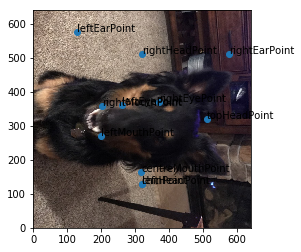

In [322]:
filename = '72311c78dc2f45eaa7b2bba20a9ae97a.png'

fig, ax = plt.subplots()
ax.imshow(np.rot90(np.array(Image.open(images_path+filename)),3), origin='lower')
ax.scatter(y.loc[filename][0::2], y.loc[filename][1::2])

xs = y.loc[filename][0::2]
ys = y.loc[filename][1::2]
cols = [
    'leftHeadPoint', 
    'leftEarPoint',
    'topHeadPoint',
    'rightEarPoint',
    'rightHeadPoint',
    'chinPoint',
    'leftEyePoint',
    'rightEyePoint',
    'leftMouthPoint',
    'centreMouthPoint',
    'rightMouthPoint'
]
for i in range(11):
    ax.annotate(cols[i], (xs[i], ys[i]))

In [224]:
y.loc[filename][0::2]

0_x     231.368744
1_x     539.001648
2_x     365.861511
3_x     452.946869
4_x     364.315613
5_x     285.773926
6_x     402.447693
7_x     397.294678
8_x     318.969391
9_x     290.628021
10_x    287.020935
Name: 0f7189d642e74507b6e08b7f4e81fa76.png, dtype: float64

In [223]:
y.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y
filename,,,,,,,,,,,,,,,,,,,,,
aea0915492e94818b5e9494c2f3fd1e0.png,149.000000,212.000000,566.000000,161.000000,299.000000,496.000000,405.000000,605.000000,110.400002,428.399994,...,324.000000,264.000000,404.000000,347.000000,293.000000,179.000000,373.000000,139.000000,422.000000,197.000000
d61b409d868b4dcda8f79b1203fb3087.png,320.000000,128.000000,518.400024,313.600006,512.000000,320.000000,541.582214,563.200012,320.000000,512.000000,...,384.000000,256.000000,384.000000,384.000000,268.799988,224.000000,267.377777,272.497772,260.551117,379.448883
d60e970de09e4680bb737756886f4527.png,303.786652,74.524429,588.799988,65.991096,531.911133,264.533325,576.000000,512.000000,515.413330,313.457794,...,366.364441,204.800003,354.417786,360.106659,133.688873,197.973328,269.653320,187.164459,181.475571,386.275543
8d29b183102b4441a309e1b42839a740.png,320.000000,128.000000,576.000000,128.000000,512.000000,320.000000,576.000000,512.000000,320.000000,512.000000,...,384.000000,256.000000,384.000000,384.000000,268.799988,224.000000,236.800003,320.000000,371.200012,224.000000
2567716590d24db786a7da6977a6f6ce.png,215.394516,242.190018,159.227051,644.854126,519.420288,638.454102,613.204468,644.854126,294.750397,580.740723,...,484.895325,291.143311,462.222229,436.972626,324.637695,241.674713,236.800003,320.000000,271.046722,449.855072


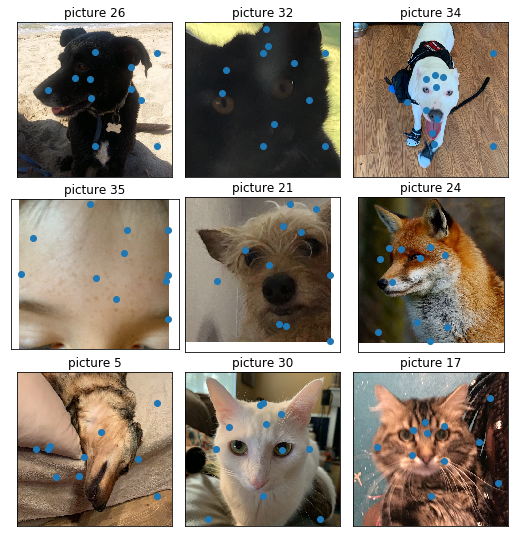

In [125]:
plot_labelled_sample(X, y, target_size, False)

In [ ]:
# TODO 
# Get the proprocessing step working for the uploaded data, maybe pass the all_data df to resize()
# Adapt the hand kp tracking for the faces